In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from scipy.optimize import curve_fit
import os
import time

In [3]:
#Following lines are to define a couple of functions that will be used later.

def rebin_sum(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).sum(axis=1)

def rebin_mean(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).mean(axis=1)

# Convert energy to a number of photons counting values falling within a particular range.
# This will always return integer photon counts.
def convert_to_photon_num_range(image):
    return np.ceil(np.divide(image - photon_range[0], np.mean(photon_range)))

# Convert energy to a number of photons using the central energy of a single photon.
# This can return fractional number of photons.`
def convert_to_photon_num_mean(image):
    return image / np.mean(photon_range)

In [16]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

#pede_file = "/sf/alvra/data/res/p16581/pedestal_20180307_2303_res.h5"
pede_file = "/sf/alvra/data/p17803/res/JF_pedestals/pedestal_20190131_1436.JF02T09V01.res.h5"
#pede_file = "/sf/alvra/data/p17803/res/JF_pedestals/pedestal_20190124_2035.JF02T09V01.res.h5"
gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V01/gains_jf02t09v01.rotated.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]
    
#print(list(gain_file.keys()))
    
print("Dimensions of G: ", G.shape)

channel_JFimages = "data/JF02T09V01/data"
channel_pulse_idsJF = "data/JF02T09V01/pulse_id"

channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"      #Mono energy in eV
channel_pulse_idsBS = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

#channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
#channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)
channel_Izero = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
#channel_Izero2 = "data/SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
#channel_Izero3 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
#channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
#channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
#channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
#channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
#channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
#channel_PALM_drift = "data/SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

Dimensions of G:  (4, 512, 9216)


In [5]:
def LoadData_JF(filename):
    with h5py.File(filename, 'r') as JF_file:
        pulse_ids = JF_file[channel_pulse_idsJF][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        image_JF_ON = JF_file[channel_JFimages][reprate_laser,:,:]
        image_JF_OFF = JF_file[channel_JFimages][:,:,:][reprate_FEL]
        
        pulse_ids_ON = pulse_ids[reprate_laser]
        pulse_ids_OFF = pulse_ids[reprate_FEL]
        
        image_roi1_ON = image_JF_ON[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_ON = image_JF_ON[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
        image_roi1_OFF = image_JF_OFF[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_OFF = image_JF_OFF[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
    return image_roi1_ON, image_roi1_OFF, image_roi2_ON, image_roi2_OFF, pulse_ids_ON, pulse_ids_OFF

def LoadData_BS(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_idsBS][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]      
        
        delay = BS_file[channel_delay][:][reprate_FEL]
        energy = BS_file[channel_energy][:][reprate_FEL]
        
    return delay, energy, Izero_pump, Izero_unpump

def LoadData_JF_crop(filename):
    with h5py.File(filename, 'r') as JF_file:
        pulse_ids = JF_file[channel_pulse_idsJF][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,)) # .ravel()
        
        image_JF = JF_file[channel_JFimages]
        
        image_roi1 = image_JF[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2 = image_JF[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
    return image_roi1, image_roi2, pulse_ids

In [6]:
DIR = "/sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_100fs_004/"
#DIR = "/sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/"
#DIR = "/sf/alvra/data/p17803/raw/"

DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

!ls -lah -t /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_100fs_004/
#!ls -lah -t /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/
#!ls -lah -t /sf/alvra/data/p17803/raw/


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 534G
drwxrwsr-x. 159 17803 p17803  32K Jan 31 22:55 ..
drwxrwsr-x.   2 root  p17803  32K Jan 31 17:55 .
-rw-r--r--.   1 root  p17803 827M Jan 31 17:55 FeBpy_monoscan_350nm_10uJ_100fs_004_step0028.BSREAD.h5
-rw-r--r--.   1 root  p17803 5.9M Jan 31 17:54 FeBpy_monoscan_350nm_10uJ_100fs_004_step0028.BSREAD_CA.h5
-rw-r--r--.   1 root  p17803 827M Jan 31 17:53 FeBpy_monoscan_350nm_10uJ_100fs_004_step0027.BSREAD.h5
-rw-r--r--.   1 17803 p17803  18G Jan 31 17:53 FeBpy_monoscan_350nm_10uJ_100fs_004_step0028.JF02T09V01.h5
-rw-r--r--.   1 root  p17803 5.7M Jan 31 17:52 FeBpy_monoscan_350nm_10uJ_100fs_004_step0027.BSREAD_CA.h5
-rw-r--r--.   1 root  p17803 827M Jan 31 17:52 FeBpy_monoscan_350nm_10uJ_100fs_004_step0026.BSREAD.h5
-rw-r--r--.   1 17803 p17803  18G Jan 31 17:52 FeBpy_monoscan_350nm_10uJ_100fs_004_step0027.JF02T09V01.h5
-rw-r--r--.   1 root  p17803 5.9M Jan 31 17:50 FeBpy_monoscan_350nm_10uJ_100fs_004_step0026.BSREAD_CA.h5
-rw-r--r--.   1 root  p17803 827M Jan 31 17:50 FeBpy_mono

ra-c-004.psi.ch
There are 87 files in the folder /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_100fs_004/


<HDF5 file "FeBpy_monoscan_350nm_10uJ_100fs_004_step0024.JF02T09V01.h5" (mode r)>
(2000, 512, 9216)


<IPython.core.display.Javascript object>


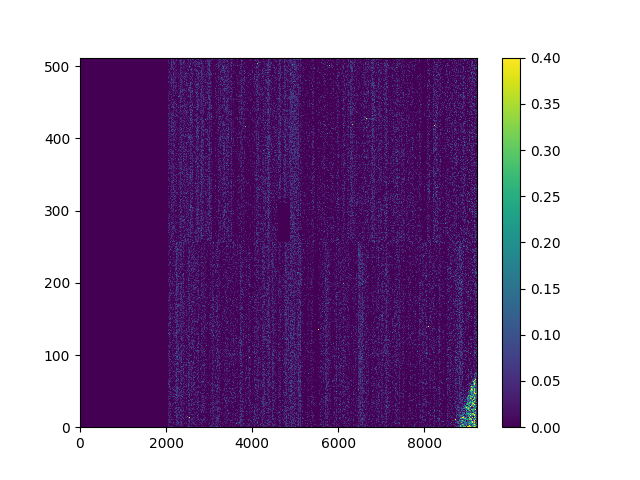

In [7]:
# First we load the first images of a file to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)

fileName = "FeBpy_monoscan_350nm_10uJ_100fs_004_step0024.JF02T09V01.h5"
#fileName = "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0010.JF02T09V01.h5"
#fileName = "CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0015.JF02T09V01.h5"

jf_file = h5py.File(DIR + fileName)

print(jf_file)

images = jf_file[channel_JFimages]
pulse_ids = jf_file[channel_pulse_idsJF]
print (images.shape)

nframes = 100

#nframes=images.shape(0)

total = 0
threshold_low = 3
threshold_high = 7

#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
roi = [[0, images.shape[1]], [0, images.shape[2]]]

for i in range(nframes):
    image = images[i][:]
    total += ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

total /= nframes


plt.figure()
plt.imshow(total, origin="lower", extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]], aspect='auto', vmin=0, vmax=0.4)
plt.colorbar()
plt.show()

# Set the ROIs (roi1 & roi2 in pixels) in the next cell

In [17]:
# Ka emission 
roi1 = [[200, 300], [6900, 7100]] # change these numbers, here they are for both crystals1 (up & down) overlapped
#roi1 = [[7030, 7130], [220, 290]]
# Kb emission 
roi2 = [[200, 300], [8300, 8450]] # change these numbers, here they are for both crystals2 (up & down) overlapped

##################################################################

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

In [18]:
G_r_roi1.ravel()[0:50]

array([41.55770111, 41.35391998, 41.88458252, 41.94208908, 42.27627182,
       42.17068481, 41.94755173, 41.49235535, 41.76924515, 41.41663361,
       41.41510773, 41.51350403, 40.53401184, 41.63269806, 42.56748962,
       41.90568924, 41.74464035, 41.62360764, 41.77641678, 41.53234482,
       41.44597626, 41.40518188, 41.48514938, 42.38697052, 41.62830734,
       42.30306625, 41.71700287, 41.2564888 , 41.94884491, 42.19672394,
       41.75641251, 41.38148117, 42.17175674, 42.43152237, 42.67982864,
       42.3752327 , 42.24145889, 42.11326218, 42.62368393, 41.73495102,
       42.58484268, 42.1942482 , 41.8980751 , 42.0892334 , 42.13450623,
       42.376194  , 42.04372787, 41.75318909, 42.61222076, 42.69366455])

In [10]:
G_r_roi1.ravel()[0:50]

array([41.55770111, 41.35391998, 41.88458252, 41.94208908, 42.27627182,
       42.17068481, 41.94755173, 41.49235535, 41.76924515, 41.41663361,
       41.41510773, 41.51350403, 40.53401184, 41.63269806, 42.56748962,
       41.90568924, 41.74464035, 41.62360764, 41.77641678, 41.53234482,
       41.44597626, 41.40518188, 41.48514938, 42.38697052, 41.62830734,
       42.30306625, 41.71700287, 41.2564888 , 41.94884491, 42.19672394,
       41.75641251, 41.38148117, 42.17175674, 42.43152237, 42.67982864,
       42.3752327 , 42.24145889, 42.11326218, 42.62368393, 41.73495102,
       42.58484268, 42.1942482 , 41.8980751 , 42.0892334 , 42.13450623,
       42.376194  , 42.04372787, 41.75318909, 42.61222076, 42.69366455])

In [19]:
scan_name = "FeBpy_monoscan_350nm_10uJ_100fs_004"
saveDir = "/das/work/p17/p17803/alvra_beamline_scripts/testSave/"

#scan_name ="CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014"                          # you need to change  this name
#saveDir = "/das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_crop/"    # dest folder (needs to exist)

######################################################################################
start_time = time.time()

intermediate_time = time.time()
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
looptime0 = time.time()
print ("Processing",numFiles,"files")

for i in range(28,numFiles):
    print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][1])))
    
    (Image_roi1, Image_roi2, Pulse_ids) = LoadData_JF_crop(str(data['scan_files'][i][1]))
    
    nframes = Pulse_ids.size
    #nframes = 10
    fn = str(saveDir + scan_name + "_crop_" + str(i) +".h5")
    with h5py.File(fn, "w") as file2write:
        grp = file2write.create_group("JF02T09V01_crop")
        dstroi1 = grp.create_dataset("roi1", shape = (nframes,) + mask_r_roi1.shape)
        dstroi2 = grp.create_dataset("roi2", shape = (nframes,) + mask_r_roi2.shape)
        dstPID = grp.create_dataset("pulse_ids", shape=(nframes, ), dtype=np.uint64)
        dstPID[:] = Pulse_ids[0:nframes]
    
        for j in range(nframes):
            image_2D_roi1 = Image_roi1[j,:,:]
            image_2D_roi1= ju.apply_gain_pede(image_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False) 
            dstroi1[j,:,] = image_2D_roi1
        
            image_2D_roi2 = Image_roi2[j,:,:]
            image_2D_roi2= ju.apply_gain_pede(image_2D_roi2, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
            dstroi2[j,:,:] = image_2D_roi2
            
    print ("It took",round((time.time() - intermediate_time),2),"s to process this file")
    intermediate_time = time.time()

print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",numFiles,"file(s)")


/sf/alvra/data/p17803/res/scan_info/FeBpy_monoscan_350nm_10uJ_100fs_004_scan_info.json
Processing 29 files
step 29 of 29 : Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_100fs_004/FeBpy_monoscan_350nm_10uJ_100fs_004_step0028.JF02T09V01.h5
It took 3.6 s to process this file
Job done! It took 3.6 seconds to process 29 file(s)


In [ ]:
print (image_2D_roi1.shape)
print (Image_roi1.shape)

In [ ]:
fn = str(saveDir + scan_name + "_" + str(numFiles) + "_crop.h5")

In [ ]:
!h5ls /das/work/p17/p17803/alvra_beamline_scripts/Test_save/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop.h5 -rd 

In [21]:
#fn = "/das/work/p17/p17803/alvra_beamline_scripts/Test_save/FeBpy_monoscan_350nm_10uJ_500fs_007_crop_0.h5"
jf_file = h5py.File(fn)
imageROI1 = jf_file["JF02T09V01_crop/roi1"]
h5py.File.close

KeyError: 'Unable to open object (component not found)'

In [19]:
imageROI1.shape

NameError: name 'imageROI1' is not defined

<IPython.core.display.Javascript object>


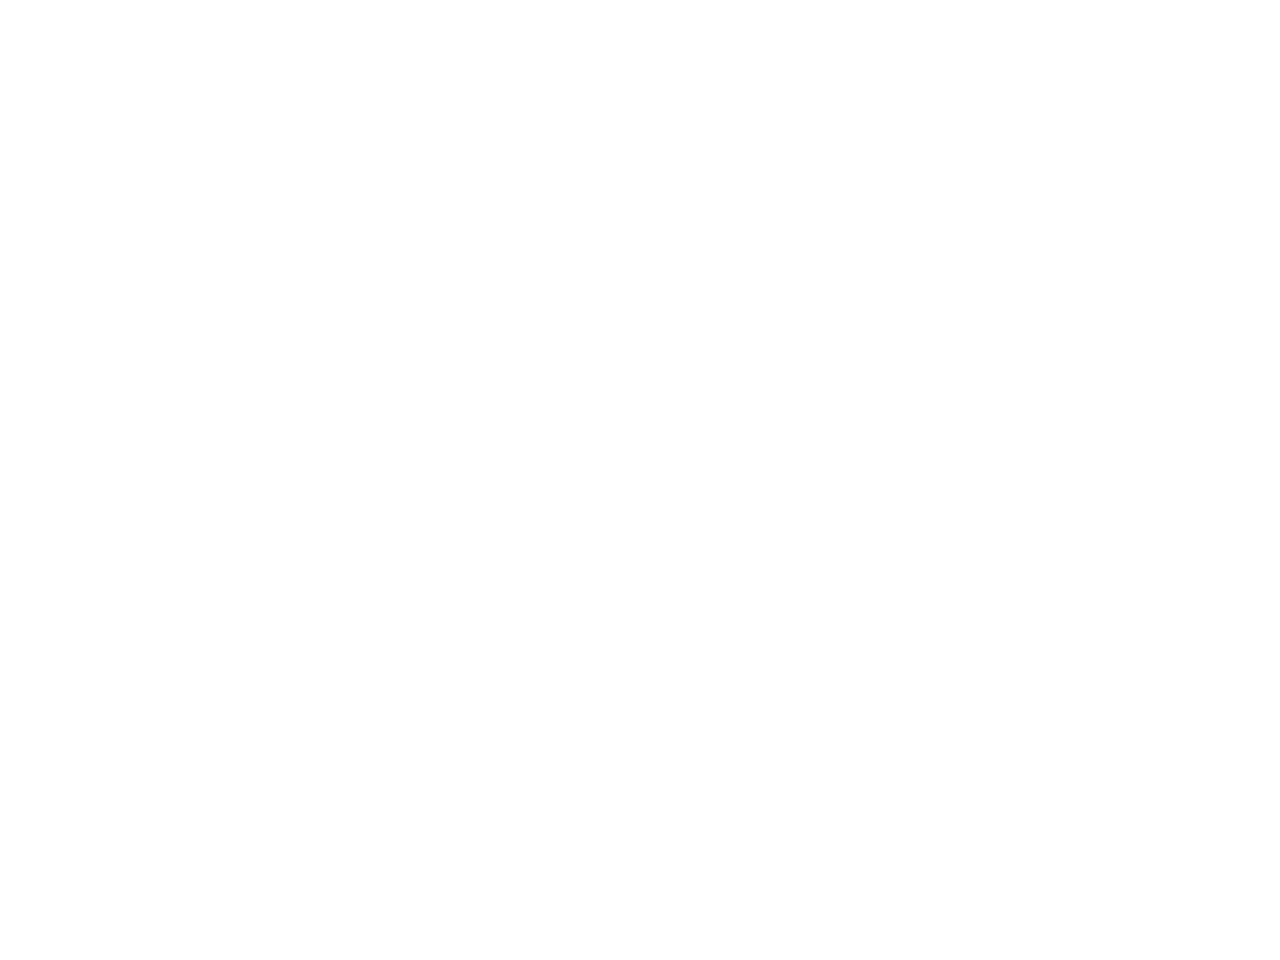

NameError: name 'imageROI1' is not defined

In [20]:
plt.figure()
plt.imshow(imageROI1[2], aspect='auto')
plt.colorbar()
plt.show()